In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datareader import DataReader
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

In [16]:
vocab, sentences = DataReader().main(vocab_limit=20000, datatype='wiki')
print("Length of vocabulary: {}".format(len(vocab)))
print("Length of corpus : {}".format(len(sentences)))

Length of vocabulary: 20000
Length of corpus : 20360


In [3]:
np.random.seed(0)

In [17]:
class Model:
    
    def __init__(self):
        pass
    
    def negativeSampling(self, sentences, vocab_size):
        
        """
        -----------------------------------------------------------
        Description :
        Calculates the negative sampling distribution of an array of words
        
        Input:
        sentences -- a list of integers [0, 1, 2, ....] , each integer represents word idx
        vocab_size -- an integer representing the vocabulary size
        
        Return:
        p_w -- a numpy ndarray containing the negative sampling distribution of the words
        ------------------------------------------------------------
        
        """
        
        word_count_keeper = np.zeros(vocab_size)
        
        total_word_count = sum(len(sentence) for sentence in sentences)
        
        for sentence in sentences:
            for word in sentence:
                word_count_keeper[word] += 1
                
        assert(np.all(word_count_keeper > 0))
        
        p_w = word_count_keeper ** 0.75
        p_w = p_w / p_w.sum()
        
        assert(np.all(p_w > 0))
        
        return p_w
    
    
    def getContext(self, pos, sentence, window_size):
        
        """
        ------------------------------------------------------
        Description:
        Function to get the context words surrounding the middle word
        
        where the input sentence is x x x x c c c c p c c c c x x x x
        and the return is [c c c c c c c c]
        
        Input:
        pos -- an integer representing the position of the middle word
        sentence -- a list of integer [0, 1, 2, ...] representing the word idx in a sentence
        window_size -- an integer representing the window size for extracting context words
        
        Return :
        context -- a list containing the context words surrounding the middle word
        ------------------------------------------------------
        """
        
        start = max(0, pos-window_size)
        end = min(len(sentence), pos+window_size)
        
        context = []
        
        for ctx_pos, ctx_word_id in enumerate(sentence[start:end], start=start):
            
            if ctx_pos != pos:
                context.append(ctx_word_id)
                
        return context
    
    
    def sigmoid(self, z):
        
        """
        -----------------------------------------------
        Description:
        Function to calculate the sigmoid function of a variable
        
        Formula :
         
         1 / (1 + e ^ -x)
        
        Input:
        z -- a numpy nd-array containing the float point values
        
        Return :
        sig -- a numpy nd-array containing the sigmoid values
        ----------------------------------------------
        
        """
        sig = 1 / (1 + np.exp(-z))
        
        return sig
    
    
    def SGD(self, word, context, label, W1, W2, lr):
        """
        -----------------------------------------------------
        Description : 
        Function to calculate the SGD optimization of weights
        
        Input:
        word -- an integer value representing a word index
        context -- a numpy nd-array containing an array of integers
        label -- an integer value representing if it's positive or negative (1/0)
        W1 -- a numpy nd-array containing floating point value representing weights for layer 1
        W2 -- a numpy nd-array containing floating point value representing weights for layer 2
        lr -- a floating point value representing learning rate for the network
        
        Return :
        loss -- a floating point value representing the categorical cross entropy value
        -------------------------------------------------------
        """
        
        pred = self.sigmoid(W1[word].dot(W2[:,context]))
        gW2 = np.outer(W1[word], (pred - label))
        gW1 = np.sum((pred-label)*W2[:, context], axis = 1)
        
        W2[:, context] -= lr * gW2
        W1[word] -= lr * gW1
        
        loss = -np.sum((label * np.log(pred + 1e-10)) + (1 - label) * np.log(1 - pred + 1e-10)) / pred.shape[0]
        
        return loss
        
        
        
    
    def train(self, vocab, sentences, epochs=20, lr=25*1e-3, lr2=1e-4, window_size=5, hidden=100):
        """
        ---------------------------------------------
        Description :
        Function to train the 2-layered network using SGD optimization
        
        Input :
        vocab -- a python-dict containing a (word,idx) pair {word:idx}
        sentences -- a python list containing list of integers which are actually word idxs in a sentence
        epochs -- a integer representing number of turns for training. Default = 20
        lr -- a float value representing initial learning rate for the network. Default = 1e-3 * 25
        lr2 -- a float value representing final learning rate for the network. Default = 1e-4
        window_size -- a integer value representing the window-size for context and middle word. Default = 5
        hidden -- a integer value representing the hidden layer dimension. Default = 100
        
        Return :
        costs -- a python list containing the error after each epoch
        W1 -- a numpy ndarray representing weights for layer 1
        W2 -- a numpy ndarray representing weights for layer 2
        ----------------------------------------------
        
        """
        
        p_w = self.negativeSampling(sentences, len(vocab))
        
        threshold = 1e-5
        
        p_drop = 1 - np.sqrt(threshold/p_w)
        
        V = len(vocab)
        D = hidden
        
        W1 = np.random.randn(V, D) / np.sqrt(V)
        W2 = np.random.randn(D, V) / np.sqrt(V)
        
        
        costs = []
        lr_decay = (lr - lr2) / epochs
        
        
        for epoch in range(epochs):
            np.random.shuffle(sentences)
            
            cost = 0
            counter = 0
            t0 = datetime.now()
            
            for sentence in tqdm(sentences):

                sentence = [word for word in sentence if np.random.random() < (1 - p_drop[word])]

                if len(sentence) < 2:
                    continue

                randomly_positioned = np.random.choice(len(sentence), size=len(sentence), replace=False)

                for pos in randomly_positioned:

                    word = sentence[pos]

                    context_words = self.getContext(pos, sentence, window_size)
                    neg_word = np.random.choice(V, p=p_w)

                    targets = np.array(context_words)

                    loss = self.SGD(word, targets, 1, W1, W2, lr)

                    cost += loss

                    loss = self.SGD(neg_word, targets, 0, W1, W2, lr)

                    cost += loss
                
                counter += 1
                
            costs.append(cost)
            print("Epoch : {}, Cost : {}, time: {}".format(epoch, cost, datetime.now() - t0))
            
            lr -= lr_decay
            
        
        return costs, W1, W2


In [18]:
costs, W1, W2 = Model().train(vocab, sentences)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:178: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch : 0, Cost : 174913.99718794544, time: 0:00:51.140617



Epoch : 1, Cost : 174322.56090709, time: 0:00:50.049444



Epoch : 2, Cost : 173660.28528743898, time: 0:00:50.814685



Epoch : 3, Cost : 173630.09380081567, time: 0:00:49.117157



Epoch : 4, Cost : 173663.16518526556, time: 0:00:49.374893



Epoch : 5, Cost : 173569.4946694666, time: 0:00:49.162648



Epoch : 6, Cost : 173543.44491052194, time: 0:00:49.315975



Epoch : 7, Cost : 172770.10592737197, time: 0:00:49.024527



Epoch : 8, Cost : 173405.46730468635, time: 0:00:49.207701



Epoch : 9, Cost : 173099.61366547822, time: 0:00:48.955111



Epoch : 10, Cost : 172257.5190456481, time: 0:00:49.322811



Epoch : 11, Cost : 172997.0524767636, time: 0:00:49.540172



Epoch : 12, Cost : 172609.36421519297, time: 0:00:57.714590



Epoch : 13, Cost : 172721.68986269046, time: 0:01:16.137061



Epoch : 14, Cost : 172318.3798245316, time: 0:01:15.549277



Epoch : 15, Cost : 172296.88946770228, time: 0:01:15.985757



Epoch : 16, Cost : 171338.07475954117, time: 0:01:19.580393



Epoch : 17, Cost : 170743.75295020448, time: 0:01:21.351288



Epoch : 18, Cost : 171582.54973872344, time: 0:01:16.689359



Epoch : 19, Cost : 170896.62879082322, time: 0:01:21.140077


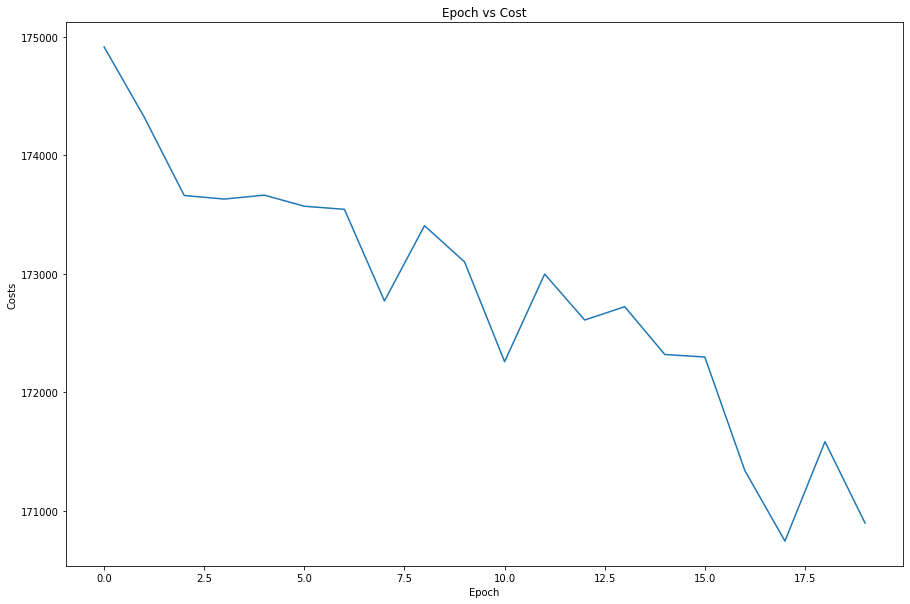

In [19]:
plt.figure(figsize=(15,10))
plt.plot(costs)
plt.title("Epoch vs Cost")
plt.xlabel("Epoch")
plt.ylabel("Costs")
plt.show()

In [20]:
print("shape of W1 : {}".format(W1.shape))
print("shape of W2 : {}".format(W2.shape))

shape of W1 : (20000, 100)
shape of W2 : (100, 20000)


In [21]:
class Analogy:
    def __init__(self):
        pass
    
    def test_analogy(self, vocab, W1, W2):
        """
        -------------------------------------------------
        Description :
        Function to test analogy of words using the embeddings trained on the wikipedia corpus

        Input :
        vocab -- a python dictionary representing word and it's index as key-value pair
        W1 -- a numpy nd-array representing embedding created in the first layer
        W2 -- a numpy nd-array representing embedding created in the second layer

        Return :
        None
        --------------------------------------------------
        """

        idx2word = {v:k for k,v in vocab.items()}

        ### We will check analogy using the first layer embedding
        ### and also using an average of the 1st and 2nd layer embedding matrices

        for We in (W1, (W1 + W2.T) / 2, W2.T):
            print("*"*10)
            self.analogy("king", "man", "queen", "woman", vocab, idx2word, We)
            self.analogy("king", "prince", "queen", "princess", vocab, idx2word, We)
            self.analogy("man", "woman", "he", "she", vocab, idx2word, We)
            self.analogy("man", "woman", "uncle", "aunt", vocab, idx2word, We)
            self.analogy("france", "paris", "japan", "tokyo", vocab, idx2word, We)



    def analogy(self, word1, word2, word3, word4, vocab, idx2word, We):
        """
        ------------------------------------------
        Description :
        Function to derive analogies of word using the formula
        word1 - word2 + word4 = word3 where we need to predict word2 and check with the function's input word3

        Input :
        word1 -- a python string representing a word
        word2 -- a python string representing a word
        word3 -- a python string representing a word
        word4 -- a python string representing a word
        vocab -- a python dictionary representing a word and it's index as key-value pair
        idx2word -- a python dictionary representing index and word as key-value pair (reverse of vocab)
        We -- a numpy nd-array representing the Word-Embedding matrix

        Return :
        None 
        -----------------------------------------
        """

        V, D = We.shape

        for w in (word1, word2, word3, word4):
            if w not in vocab:
                print("Oops!! I'vent learnt about this word. This is so wrong.....")
                return

        v1 = We[vocab[word1]]
        v2 = We[vocab[word2]]
        v3 = We[vocab[word3]]
        v4 = We[vocab[word4]]

        pred = v1 - v2 + v4

        distance = pairwise_distances(pred.reshape(1, D), We, metric='cosine').reshape(V)
        idx = distance.argsort()[:10]
        best_idx = -1
        keep_out = [vocab[w] for w in (word1, word2, word4)]
        for i in idx:
            if i not in keep_out:
                best_idx = i
                break

        print("Got {} - {} = {} - {}".format(word1, word2, idx2word[best_idx], word4))




In [22]:
Analogy().test_analogy(vocab, W1, W2)

**********
Got king - man = martin - woman
Got king - prince = when - princess
Got man - woman = singer - she
Oops!! I'vent learnt about this word. This is so wrong.....
Got france - paris = great - tokyo
**********
Got king - man = luther - woman
Got king - prince = was - princess
Got man - woman = married - she
Oops!! I'vent learnt about this word. This is so wrong.....
Got france - paris = republic - tokyo
**********
Got king - man = barack - woman
Got king - prince = macbeth - princess
Got man - woman = her - she
Oops!! I'vent learnt about this word. This is so wrong.....
Got france - paris = russia - tokyo
